<a href="https://colab.research.google.com/github/bahducoup/nlptrading/blob/main/experiments/RL_run_through.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/bahducoup/nlptrading.git

Cloning into 'nlptrading'...
remote: Enumerating objects: 84, done.
remote: Counting objects: 100% (84/84), done.
remote: Compressing objects: 100% (65/65), done.
remote: Total 84 (delta 29), reused 63 (delta 13), pack-reused 0
Unpacking objects: 100% (84/84), done.


In [2]:
!pip install stockstats
!pip install stable_baselines3
!pip install pyfolio
%pip install PyPortfolioOpt
%pip install plotly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 177 kB 4.7 MB/s 
     |████████████████████████████████| 1.5 MB 47.6 MB/s 
  Created wheel for gym: filename=gym-0.21.0-py3-none-any.whl size=1616826 sha256=fe050a788e279a741716b2f605d229bf2a2dc3abe8c4b4a73177bf9928272415
  Stored in directory: /root/.cache/pip/wheels/76/ee/9c/36bfe3e079df99acf5ae57f4e3464ff2771b34447d6d2f2148
Successfully built gym
  Attempting uninstall: gym
    Found existing installation: gym 0.17.3
    Uninstalling gym-0.17.3:
      Successfully uninstalled gym-0.17.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 91 kB 4.5 MB/s 
     |████████████████████████████████| 52 kB 1.8 MB/s 
  Created wheel for pyfolio: filename=pyfolio-0.9.2-py3-

In [3]:
#Hyperparams:
start_year = 2005
train_start = '2005-01-01'
dev_start = '2014-01-01'
test_start = '2016-01-01'
test_end = '2022-06-06'

#TODO: Remove subset of stocks

In [4]:
import sys
sys.path.append('../')
#to run processing of python files, run this command:

from google.colab import auth
auth.authenticate_user()

Uncomment next section to download data

In [5]:
# bucket_name = 'nlptrading-dataset'
# !gsutil cp gs://{bucket_name}/test_df.csv test_df.csv
# !gsutil cp gs://{bucket_name}/train_df.csv train_df.csv
# !mv train_df.csv nlptrading/dataset/train_df.csv
# !mv test_df.csv nlptrading/dataset/test_df.csv

Copying gs://nlptrading-dataset/test_df.csv...
- [1 files][384.5 MiB/384.5 MiB]                                                
Operation completed over 1 objects/384.5 MiB.                                    
Copying gs://nlptrading-dataset/train_df.csv...
- [1 files][882.5 MiB/882.5 MiB]   67.2 MiB/s                                   
Operation completed over 1 objects/882.5 MiB.                                    


In [6]:
import pandas as pd
import numpy as np
from copy import deepcopy

In [7]:
#loads data
train_df = pd.read_csv('nlptrading/dataset/train_df.csv', index_col=0)
train_df['Date'] = pd.to_datetime(train_df['Date'])

test_df = pd.read_csv('nlptrading/dataset/test_df.csv', index_col=0)
test_df['Date'] = pd.to_datetime(test_df['Date'])

In [8]:
train_df['Return'] = 1 + (train_df.Close - train_df.Open)/train_df.Open
train_df['Day_of_week'] = train_df['Date'].dt.weekday
train_df = pd.concat([train_df,pd.get_dummies(train_df.Day_of_week, prefix='weekday')], axis=1)

test_df['Return'] = 1 + (test_df.Close - test_df.Open)/test_df.Open
test_df['Day_of_week'] = test_df['Date'].dt.weekday
test_df = pd.concat([test_df,pd.get_dummies(test_df.Day_of_week, prefix='weekday')], axis=1)

train_df

,Date,Low,Open,Volume,High,Close,Adjusted Close,Symbol,Return,Day_of_week,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4
0,1990-06-28,9.968750,10.093750,176400.0,10.093750,9.968750,2.215101,RIO,0.987616,3,0,0,0,1,0
1,1990-06-29,10.000000,10.031250,69200.0,10.062500,10.062500,2.235931,RIO,1.003115,4,0,0,0,0,1
2,1990-07-02,10.000000,10.000000,62000.0,10.031250,10.031250,2.228988,RIO,1.003125,0,1,0,0,0,0
3,1990-07-03,10.031250,10.031250,29600.0,10.062500,10.062500,2.235931,RIO,1.003115,1,0,1,0,0,0
4,1990-07-05,9.656250,9.718750,31200.0,9.718750,9.687500,2.152606,RIO,0.996785,3,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18936070,2015-12-24,71.940002,71.949997,243800.0,72.570000,72.349998,67.721214,MSCI,1.005559,3,0,0,0,1,0
18936071,2015-12-28,71.769997,72.169998,444300.0,72.449997,72.379997,67.749298,MSCI,1.002910,0,1,0,0,0,0
18936072,2015-12-29,72.330002,72.760002,266800.0,73.379997,72.849998,68.189255,MSCI,1.001237,1,0,1,0,0,0
18936073,2015-12-30,72.489998,72.660004,245200.0,73.440002,72.589996,67.945869,MSCI,0.999037,2,0,0,1,0,0


Preprocessing data- This is directly taken from FinRL

In [9]:
from nlptrading.src.data_processing.data_preprocessor import DataProcessor


In [10]:
data_processor = DataProcessor()
clean_train = len(data_processor.clean_data(train_df[train_df.Date.dt.year>=start_year]).Symbol.unique())

hi


In [11]:
# stockstats technical indicator column names
# check https://pypi.org/project/stockstats/ for different names
INDICATORS = [
    "macd",
    "boll_ub",
    "boll_lb",
    "rsi_30",
    "cci_30",
    "dx_30",
    "close_30_sma",
    "close_60_sma",
]

use_technical_indicator = True
use_turbulence = True
user_defined_feature = True



def preprocess_data(df):
    """main method to do the feature engineering
    @:param config: source dataframe
    @:return: a DataMatrices object
    """
    # clean data
    df = data_processor.clean_data(df)

    # add technical indicators using stockstats
    if use_technical_indicator:
        df = data_processor.add_technical_indicator(df, INDICATORS)
        print("Successfully added technical indicators")

    # add vix for multiple stock 
    # (This is an indicator of how volatile the market is as a whole)
    # if self.use_vix:
    #     df = self.add_vix(df)
    #     print("Successfully added vix")

    # add turbulence index for multiple stock
    if use_turbulence:
        df = data_processor.add_turbulence(df)
        print("Successfully added turbulence index")

    # add user defined feature
    if user_defined_feature:
        df = data_processor.add_user_defined_feature(df)
        print("Successfully added user defined features")

    # fill the missing values at the beginning and the end
    df = df.fillna(method="ffill").fillna(method="bfill")
    return df

In [12]:
import random

#takes 10 sec to run
stock_symbols = data_processor.clean_data(train_df[train_df.Date.dt.year>=start_year]).Symbol.unique()
random.shuffle(stock_symbols)
stock_list = list(stock_symbols[:100])
len(stock_list)

100

In [13]:
stock_list = ['AB', 'ABG', 'ABM', 'ADP', 'ALV', 'ANIK', 'ASR', 'BELFB', 'BGT', 'BHE', 'BHLB', 'BSX', 'CAKE', 'CCMP', 'COLB', 'COLM', 'CPRT', 'CTAS', 'DDAIF', 'DGII', 'DIS', 'DTE', 'EAT', 'ED', 'EGO', 'EQIX', 'EZPW', 'FDS', 'FMX', 'FRO', 'GGAL', 'GOOD', 'GPI', 'GSK', 'HELE', 'HEP', 'HLIT', 'HPS', 'INCY', 'INT', 'IP', 'JCI', 'KB', 'KSS', 'LAD', 'LEE', 'MFC', 'MGA', 'MGF', 'MIY', 'MOH', 'MPWR', 'MRCY', 'MSD', 'MVIS', 'NGS', 'NOK', 'NS', 'NWPX', 'OCN', 'OSTK', 'OXM', 'PEGA', 'PKG', 'PMX', 'PSB', 'RBCAA', 'RIG', 'RQI', 'RUSHA', 'RWT', 'SAM', 'SBGI', 'SFE', 'SRCL', 'SSYS', 'SWK', 'SWKS', 'TGA', 'TGI', 'TLK', 'TSCO', 'TSM', 'TYG', 'UHS', 'UNFI', 'UTI', 'WAB', 'WABC', 'WAT', 'WTM', 'YUM', 'ZEUS']

In [15]:
#Takes 2 min to add technical indicators
#30 sec to add the rest
#takes a mile to run  (started at 10:25 [since 2005 w 1k stocks] -> 2 hours)
processed_df = preprocess_data(train_df[(train_df.Date.dt.year>=start_year) & (train_df.Symbol.isin(stock_list))])
df=train_df.sort_values(['Date','Symbol'],ignore_index=True)
df.index = df.Date.factorize()[0]
processed_df.to_csv('processed_df.csv')

Successfully added technical indicators
Successfully added turbulence index
Successfully added user defined features


In [16]:
# add covariance matrix as states
# Note, this just calculates a stock's relationhsip with other stocks and stores it in a matrix
# We can similarly take 100 common stocks, and calculate the covariance for each stock independently
# I Think
#Also, this takes the covariance over the past year
# Wouldn't it also be important to know the covariance between the past week?
# This can be a future experiment
#Takes 4 min before crashing
df=processed_df.sort_values(['Date','Symbol'],ignore_index=True)
df.index = df.Date.factorize()[0]

cov_list = []
return_list = []

# look back is one year
lookback=252
print('total indexes is', len(df.index.unique())) #should be ~553k
print('end ', len(df.index.unique()))
for i in range(lookback,len(df.index.unique())):
  data_lookback = df.loc[i-lookback:i,:]
  price_lookback=data_lookback.pivot_table(index = 'Date',columns = 'Symbol', values = 'Close')
  return_lookback = price_lookback.pct_change().dropna()
  return_list.append(return_lookback)

  covs = return_lookback.cov().values 
  cov_list.append(covs)


        

total indexes is 2769
end  2769


In [17]:
df_cov = pd.DataFrame({'Date':df.Date.unique()[lookback:],'cov_list':cov_list,'return_list':return_list})
#df_cov = pd.DataFrame({'Date':df.Date.unique()[lookback:],'return_list':return_list})
df = df.merge(df_cov, on='Date')
df = df.sort_values(['Date','Symbol']).reset_index(drop=True)

In [18]:
# If working on RL part, can save df to cloud bucket
# rl_df_file_name = 'rl_df.pkl'
# bucket_name = 'nlptrading-dataset'
# #!gsutil cp {rl_df_file_name} gs://{bucket_name}/{rl_df_file_name}
# !gsutil cp gs://{bucket_name}/{rl_df_file_name} {rl_df_file_name}

# rl_df_file_name = 'rl_df.pkl'
# df = pd.read_pickle(rl_df_file_name)
# df.to_pickle(rl_df_file_name) #this file is .7 GB -> 8 GB

# !ls -lh rl_df.pkl

In [19]:
train = data_processor.data_split(df, train_start,dev_start)

In [20]:
from nlptrading.src.reinforce_learning.trading_env.env_portfolio import StockPortfolioEnv

In [21]:
stock_dimension = len(train.Symbol.unique())
state_space = stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 93, State Space: 93


In [22]:
env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "transaction_cost_pct": 0.001, 
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": INDICATORS, 
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4
    
}

e_train_gym = StockPortfolioEnv(df = train, **env_kwargs)

In [23]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


In [24]:
from nlptrading.src.reinforce_learning.agents.drl_agent import DRLAgent

In [25]:
agent = DRLAgent(env = env_train)
A2C_PARAMS = {"n_steps": 5, "ent_coef": 0.005, "learning_rate": 0.0002}
model_a2c = agent.get_model(model_name="a2c",model_kwargs = A2C_PARAMS)

{'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.0002}
Using cuda device


In [27]:
!mkdir results

In [28]:
trained_a2c = agent.train_model(model=model_a2c, 
                                tb_log_name='a2c',
                                total_timesteps=50000) #should take ~18 min w CPU (3 min for 50000 timestamps w GPU)

-------------------------------------
| time/                 |           |
|    fps                | 198       |
|    iterations         | 100       |
|    time_elapsed       | 2         |
|    total_timesteps    | 500       |
| train/                |           |
|    entropy_loss       | -131      |
|    explained_variance | -2.38e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 501       |
|    policy_loss        | 4.2e+08   |
|    reward             | 1180409.4 |
|    std                | 0.995     |
|    value_loss         | 1.45e+13  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 211       |
|    iterations         | 200       |
|    time_elapsed       | 4         |
|    total_timesteps    | 1000      |
| train/                |           |
|    entropy_loss       | -131      |
|    explained_variance | 0         |
|    learning_rate      | 0.0002    |
|    n_updat

In [29]:
trade = data_processor.data_split(df,dev_start, test_start)
e_trade_gym = StockPortfolioEnv(df = trade, **env_kwargs)

In [30]:
df_daily_return, df_actions = DRLAgent.DRL_prediction(model=model_a2c,
                        environment = e_trade_gym)

begin_total_asset:1000000
end_total_asset:1010129.5623054934
Sharpe:  0.10573827150589288
hit end!


In [31]:
df_daily_return

,Date,daily_return
0,2014-01-02,0.000000
1,2014-01-03,0.002192
2,2014-01-06,-0.003029
3,2014-01-07,0.009519
4,2014-01-08,-0.000082
...,...,...
499,2015-12-24,0.000973
500,2015-12-28,-0.007997
501,2015-12-29,0.009372
502,2015-12-30,-0.008616


In [32]:
df_daily_return.to_csv('df_daily_return.csv')

In [33]:
df_actions.head()

,AB,ABG,ABM,ADP,ALV,ANIK,ASR,BELFB,BGT,BHE,...,TYG,UHS,UNFI,UTI,WAB,WABC,WAT,WTM,YUM,ZEUS
Date,,,,,,,,,,,,,,,,,,,,,
2014-01-02,0.010753,0.010753,0.010753,0.010753,0.010753,0.010753,0.010753,0.010753,0.010753,0.010753,...,0.010753,0.010753,0.010753,0.010753,0.010753,0.010753,0.010753,0.010753,0.010753,0.010753
2014-01-03,0.007121,0.019357,0.019357,0.011925,0.007913,0.012277,0.010279,0.007121,0.007121,0.007121,...,0.015454,0.008827,0.019357,0.013356,0.007121,0.008644,0.011569,0.007121,0.007121,0.007746
2014-01-06,0.007121,0.019357,0.019357,0.011925,0.007913,0.012277,0.010279,0.007121,0.007121,0.007121,...,0.015454,0.008827,0.019357,0.013356,0.007121,0.008644,0.011569,0.007121,0.007121,0.007746
2014-01-07,0.007121,0.019357,0.019357,0.011925,0.007913,0.012277,0.010279,0.007121,0.007121,0.007121,...,0.015454,0.008827,0.019357,0.013356,0.007121,0.008644,0.011569,0.007121,0.007121,0.007746
2014-01-08,0.007121,0.019357,0.019357,0.011925,0.007913,0.012277,0.010279,0.007121,0.007121,0.007121,...,0.015454,0.008827,0.019357,0.013356,0.007121,0.008644,0.011569,0.007121,0.007121,0.007746


In [34]:
df_actions.to_csv('df_actions.csv')

In [66]:
from nlptrading.src.reinforce_learning.postprocessing.postprocessing import get_daily_return, \
   backtest_stats, convert_daily_return_to_pyfolio_ts, calculate_portfolio_minimum_variance

In [53]:
# #Note: This may come in handy if timeseries was imported and the line wasn't corrected
from pyfolio import timeseries
!cp nlptrading/src/misc/timeseries.py {timeseries.__file__} 
import importlib
importlib.reload(timeseries)

<module 'pyfolio.timeseries' from '/usr/local/lib/python3.7/dist-packages/pyfolio/timeseries.py'>

In [54]:
DRL_strat = convert_daily_return_to_pyfolio_ts(df_daily_return)
perf_func = timeseries.perf_stats 
perf_stats_all = perf_func( returns=DRL_strat, 
                              factor_returns=DRL_strat, 
                                positions=None, transactions=None, turnover_denom="AGB")

In [55]:
print("==============DRL Strategy Stats===========")
perf_stats_all

==============DRL Strategy Stats===========


Annual return          0.005052
Cumulative returns     0.010130
Annual volatility      0.139075
Sharpe ratio           0.105738
Calmar ratio           0.033068
Stability              0.181496
Max drawdown          -0.152776
Omega ratio            1.017397
Sortino ratio          0.146131
Skew                  -0.245850
Kurtosis               0.666946
Tail ratio             0.929487
Daily value at risk   -0.017463
Alpha                  0.000000
Beta                   1.000000
dtype: float64

In [56]:
def get_baseline(ticker, start, end):
    return train_df[(train_df.Symbol.isin(ticker))&(train_df.Date >= start)&(train_df.Date < end)]


def get_baseline_test(ticker, start, end):
    return test_df[(test_df.Symbol.isin(ticker))&(test_df.Date >= start)&(test_df.Date < end)]

    # return YahooDownloader(
    #     start_date=start, end_date=end, ticker_list=[ticker]
    # ).fetch_data()


In [44]:
df_daily_return

,Date,daily_return
0,2014-01-02,0.000000
1,2014-01-03,0.002192
2,2014-01-06,-0.003029
3,2014-01-07,0.009519
4,2014-01-08,-0.000082
...,...,...
499,2015-12-24,0.000973
500,2015-12-28,-0.007997
501,2015-12-29,0.009372
502,2015-12-30,-0.008616


In [58]:
#baseline stats
print("==============Get Baseline Stats===========")
print('skipped')
baseline_df = get_baseline(
        ticker=stock_list,
        start = df_daily_return.loc[0,'Date'],
        end = df_daily_return.loc[len(df_daily_return)-1,'Date'])

stats = backtest_stats(baseline_df, value_col_name = 'Close')

==============Get Baseline Stats===========
skipped
Annual return         -0.008714
Cumulative returns    -0.803043
Annual volatility      5.601946
Sharpe ratio           0.192349
Calmar ratio          -0.008747
Stability              0.013940
Max drawdown          -0.996262
Omega ratio            1.605033
Sortino ratio          2.832601
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.990711
Daily value at risk   -0.701503
dtype: float64


Date
2014-01-03 00:00:00+00:00    0.012631
2014-01-06 00:00:00+00:00   -0.004919
2014-01-07 00:00:00+00:00    0.014301
2014-01-08 00:00:00+00:00    0.016362
2014-01-09 00:00:00+00:00    0.000342
                               ...   
2015-12-24 00:00:00+00:00    0.008858
2015-12-28 00:00:00+00:00   -0.008543
2015-12-29 00:00:00+00:00    0.013882
2015-12-30 00:00:00+00:00   -0.004485
2015-12-31 00:00:00+00:00   -0.008537
Name: daily_return, Length: 503, dtype: float64
Date
2014-01-03 00:00:00+00:00    0.002192
2014-01-06 00:00:00+00:00   -0.003029
2014-01-07 00:00:00+00:00    0.009519
2014-01-08 00:00:00+00:00   -0.000082
2014-01-09 00:00:00+00:00   -0.002472
                               ...   
2015-12-24 00:00:00+00:00    0.000973
2015-12-28 00:00:00+00:00   -0.007997
2015-12-29 00:00:00+00:00    0.009372
2015-12-30 00:00:00+00:00   -0.008616
2015-12-31 00:00:00+00:00   -0.003984
Length: 503, dtype: float64


Start date,2014-01-03
End date,2015-12-31
Total months,23
,Backtest
Annual return,0.5%
Cumulative returns,1.0%
Annual volatility,13.9%
Sharpe ratio,0.11
Calmar ratio,0.03
Stability,0.18
Max drawdown,-15.3%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,15.28,2015-04-23,2015-12-14,NaT,NaN
1,12.11,2014-07-03,2014-10-13,2014-12-18,121
2,7.32,2014-01-22,2014-02-03,2014-02-24,24
3,5.16,2014-04-02,2014-04-11,2014-06-06,48
4,3.82,2014-12-26,2015-01-15,2015-02-12,35


Stress Events,mean,min,max
Apr14,-0.04%,-2.28%,1.27%
Oct14,0.28%,-2.08%,2.12%
Fall2015,-0.22%,-3.51%,2.51%
New Normal,0.01%,-3.51%,2.52%


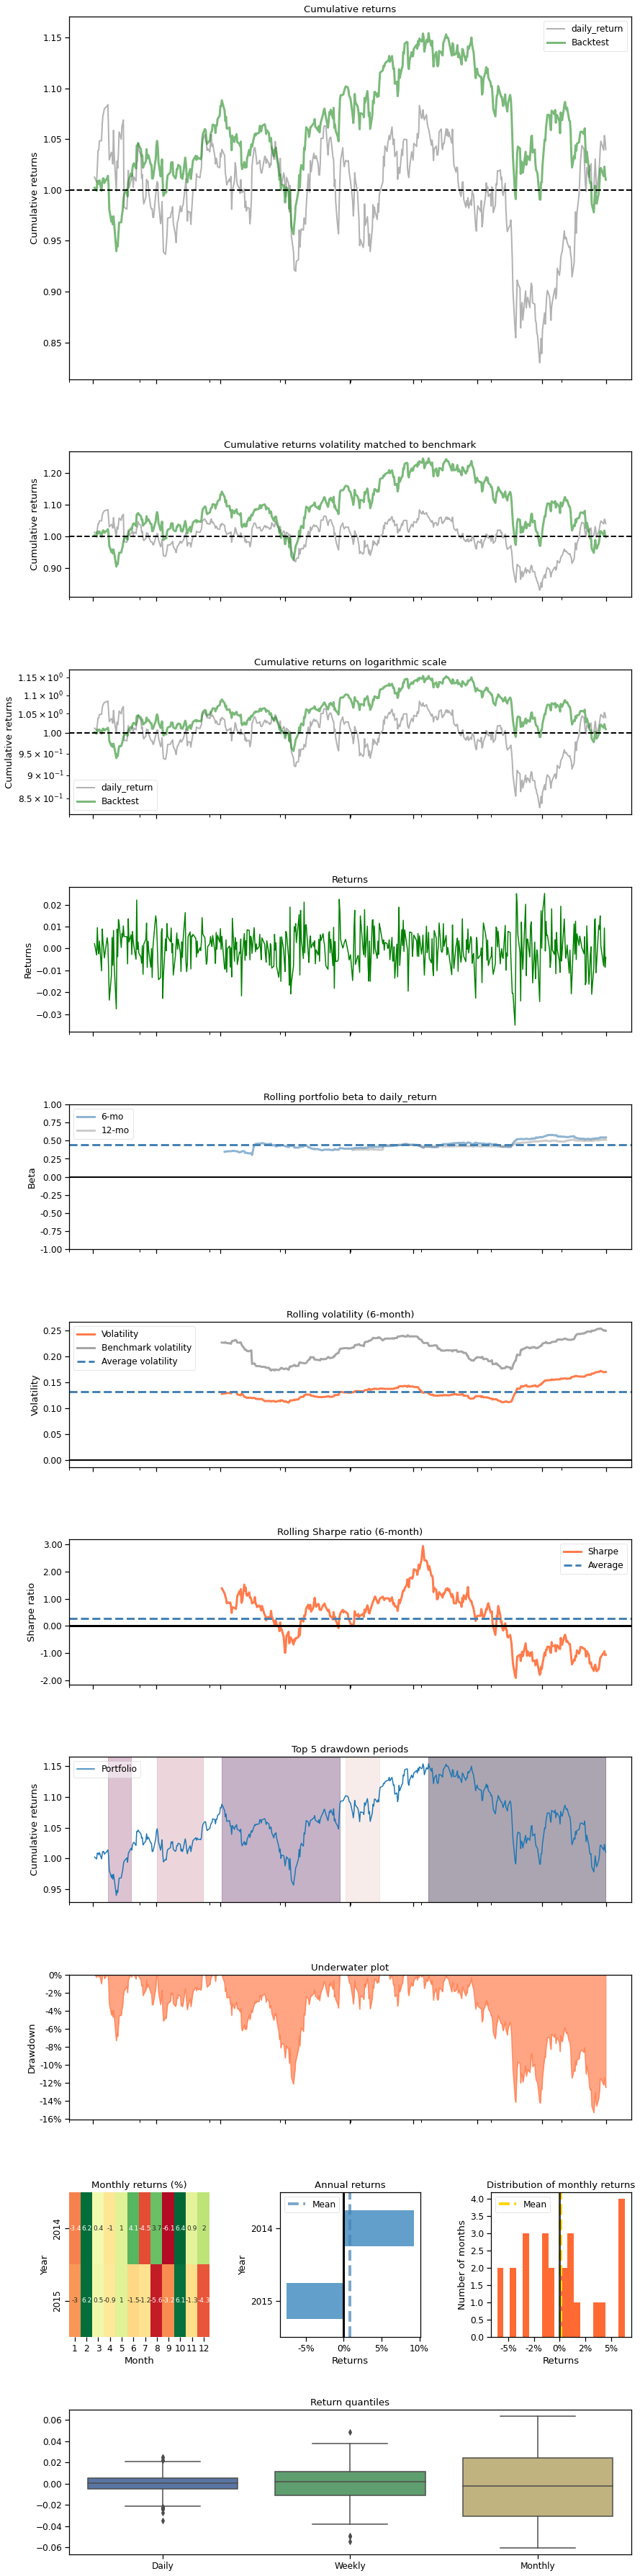

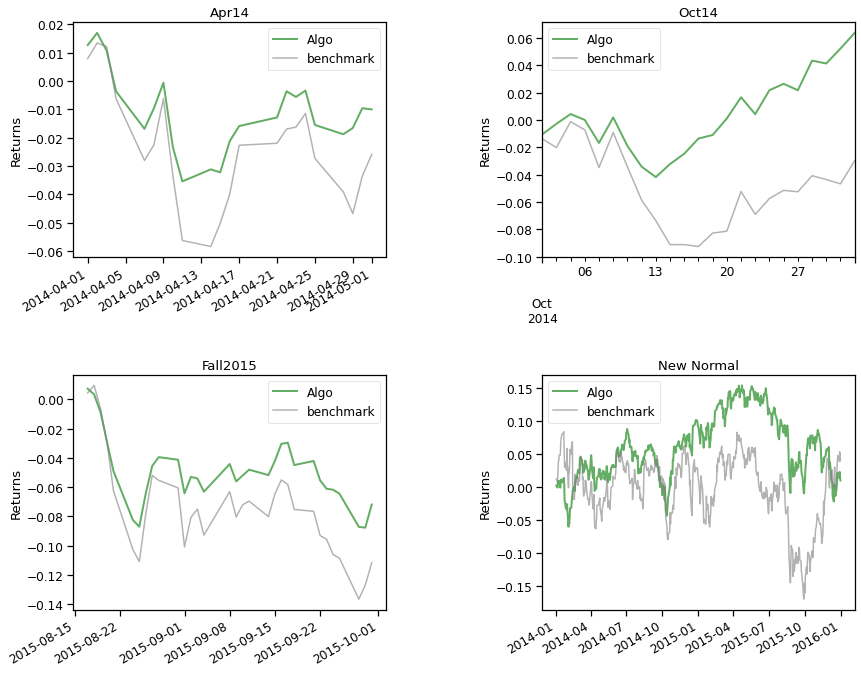

In [59]:
import pyfolio
%matplotlib inline

#ticker should be ^DJI
baseline_df = get_baseline(
        ticker=['A'],
        start=df_daily_return.loc[0,'Date'], end='2016-01-01'
    )

baseline_returns = get_daily_return(baseline_df, value_col_name="Close")
baseline_returns = baseline_returns[1:]
DRL_strat = DRL_strat[1:]
print(baseline_returns)
print(DRL_strat)
with pyfolio.plotting.plotting_context(font_scale=1.1):
        pyfolio.create_full_tear_sheet(returns = DRL_strat,
                                       benchmark_rets=baseline_returns, set_context=False)
        

In [60]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models

In [61]:
unique_tic = trade.Symbol.unique()
unique_trade_date = trade.Date.unique()

In [67]:

portfolio = calculate_portfolio_minimum_variance(df, unique_trade_date)

In [ ]:
portfolio.head()

,account_value
2014-01-02,1000000
2014-01-03,1.0023e+06
2014-01-06,1.00168e+06
2014-01-07,1.00789e+06
2014-01-08,1.00683e+06


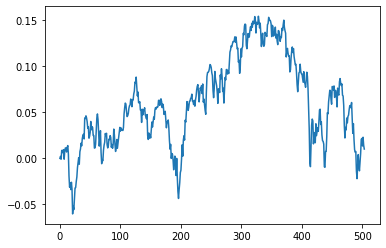

In [68]:
%matplotlib inline

a2c_cumpod =(df_daily_return.daily_return+1).cumprod()-1
min_var_cumpod =(portfolio.account_value.pct_change()+1).cumprod()-1
dji_cumpod =(baseline_returns+1).cumprod()-1

a2c_cumpod.plot()


## Plotly: DRL, Min-Variance, DJIA

In [69]:
from datetime import datetime as dt

import matplotlib.pyplot as plt
import plotly
import plotly.graph_objs as go

In [70]:
time_ind = pd.Series(df_daily_return.Date)

In [71]:
trace0_portfolio = go.Scatter(x = time_ind, y = a2c_cumpod, mode = 'lines', name = 'A2C (Portfolio Allocation)')
trace1_portfolio = go.Scatter(x = time_ind, y = dji_cumpod, mode = 'lines', name = 'DJIA')
trace2_portfolio = go.Scatter(x = time_ind, y = min_var_cumpod, mode = 'lines', name = 'Min-Variance')
#trace3_portfolio = go.Scatter(x = time_ind, y = ddpg_cumpod, mode = 'lines', name = 'DDPG')
#trace4_portfolio = go.Scatter(x = time_ind, y = addpg_cumpod, mode = 'lines', name = 'Adaptive-DDPG')
#trace5_portfolio = go.Scatter(x = time_ind, y = min_cumpod, mode = 'lines', name = 'Min-Variance')

#trace4 = go.Scatter(x = time_ind, y = addpg_cumpod, mode = 'lines', name = 'Adaptive-DDPG')

#trace2 = go.Scatter(x = time_ind, y = portfolio_cost_minv, mode = 'lines', name = 'Min-Variance')
#trace3 = go.Scatter(x = time_ind, y = spx_value, mode = 'lines', name = 'SPX')

In [90]:
import plotly.io as pio
pio.renderers.default = 'colab'

from nlptrading.src.reinforce_learning.postprocessing.plotting import plot_portfolio_traces

traces_list = [trace0_portfolio, trace1_portfolio, trace2_portfolio]
fig = plot_portfolio_traces(traces = traces_list, time_ind= time_ind)
fig.show()

# Testing Stages

In [91]:
processed_test_df = preprocess_data(test_df[(test_df.Symbol.isin(stock_list))])
df_eval=processed_test_df.sort_values(['Date','Symbol'],ignore_index=True)
df_eval.index = df_eval.Date.factorize()[0]
len(processed_df.index.unique())

Successfully added technical indicators
Successfully added turbulence index
Successfully added user defined features


257517

In [92]:
cov_list = []
return_list = []

# look back is one year
lookback=10# 252
print('total indexes is', len(df_eval.index.unique())) #should be ~553k
print('end ', len(df_eval.index.unique()))
for i in range(lookback,len(df_eval.index.unique())):
  data_lookback = df_eval.loc[i-lookback:i,:]
  price_lookback=data_lookback.pivot_table(index = 'Date',columns = 'Symbol', values = 'Close')
  return_lookback = price_lookback.pct_change().dropna()
  return_list.append(return_lookback)

  covs = return_lookback.cov().values 
  cov_list.append(covs)

print(len(cov_list), 'len of covlist')

total indexes is 1618
end  1618
1608 len of covlist


In [93]:
stock_list = list(df_eval.Symbol.unique())

In [94]:
df_cov = pd.DataFrame({'Date':df_eval.Date.unique()[lookback:],'cov_list':cov_list,'return_list':return_list})
#df_cov = pd.DataFrame({'Date':df.Date.unique()[lookback:],'return_list':return_list})
df_eval = df_eval.merge(df_cov, on='Date')
df_eval = df_eval.sort_values(['Date','Symbol']).reset_index(drop=True)

In [95]:
trade_test = data_processor.data_split(df_eval, test_start,test_end)
e_trade_gym = StockPortfolioEnv(df = trade_test, **env_kwargs)

In [97]:
env_test, _ = e_trade_gym.get_sb_env()
print(type(env_test))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


In [98]:
df_daily_return, df_actions = DRLAgent.DRL_prediction(model=model_a2c,
                        environment = e_trade_gym)

begin_total_asset:1000000
end_total_asset:2491323.73307552
Sharpe:  0.7736925878767337
hit end!


In [99]:
#WAIT STOP STOP STOP -> Read the cell above
from pyfolio import timeseries
DRL_strat = convert_daily_return_to_pyfolio_ts(df_daily_return)
perf_func = timeseries.perf_stats 
perf_stats_all = perf_func( returns=DRL_strat, 
                              factor_returns=DRL_strat, 
                                positions=None, transactions=None, turnover_denom="AGB")

In [100]:
#baseline stats
print("==============Get Baseline Stats===========")
print('skipped')
baseline_df = get_baseline_test(
        ticker=stock_list,
        start = df_daily_return.loc[0,'Date'],
        end = df_daily_return.loc[len(df_daily_return)-1,'Date'])

stats = backtest_stats(baseline_df, value_col_name = 'Close')

==============Get Baseline Stats===========
skipped
Annual return         -0.003977
Cumulative returns    -0.905776
Annual volatility      2.429656
Sharpe ratio           0.152752
Calmar ratio          -0.003978
Stability              0.045222
Max drawdown          -0.999807
Omega ratio            1.178861
Sortino ratio          1.013904
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.019789
Daily value at risk   -0.304635
dtype: float64


Date
2016-01-20 00:00:00+00:00    0.001613
2016-01-21 00:00:00+00:00   -0.000805
2016-01-22 00:00:00+00:00    0.020145
2016-01-25 00:00:00+00:00   -0.009742
2016-01-26 00:00:00+00:00   -0.002659
                               ...   
2022-05-27 00:00:00+00:00    0.054098
2022-05-31 00:00:00+00:00   -0.022903
2022-06-01 00:00:00+00:00   -0.035042
2022-06-02 00:00:00+00:00    0.048826
2022-06-03 00:00:00+00:00   -0.004725
Name: daily_return, Length: 1606, dtype: float64
Date
2016-01-20 00:00:00+00:00   -0.007128
2016-01-21 00:00:00+00:00    0.008156
2016-01-22 00:00:00+00:00    0.024212
2016-01-25 00:00:00+00:00   -0.019712
2016-01-26 00:00:00+00:00    0.020079
                               ...   
2022-05-27 00:00:00+00:00    0.020328
2022-05-31 00:00:00+00:00   -0.008770
2022-06-01 00:00:00+00:00   -0.002081
2022-06-02 00:00:00+00:00    0.019783
2022-06-03 00:00:00+00:00   -0.010621
Length: 1606, dtype: float64


Start date,2016-01-20
End date,2022-06-03
Total months,76
,Backtest
Annual return,15.4%
Cumulative returns,149.1%
Annual volatility,21.5%
Sharpe ratio,0.77
Calmar ratio,0.35
Stability,0.80
Max drawdown,-43.8%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,43.81,2020-01-16,2020-03-18,2020-08-10,148
1,22.21,2018-08-29,2018-12-24,2019-04-08,159
2,14.89,2021-11-08,2022-05-11,NaT,NaN
3,9.63,2020-08-12,2020-09-23,2020-10-09,43
4,9.11,2018-01-26,2018-04-02,2018-07-20,126


Stress Events,mean,min,max
New Normal,0.07%,-12.51%,9.58%


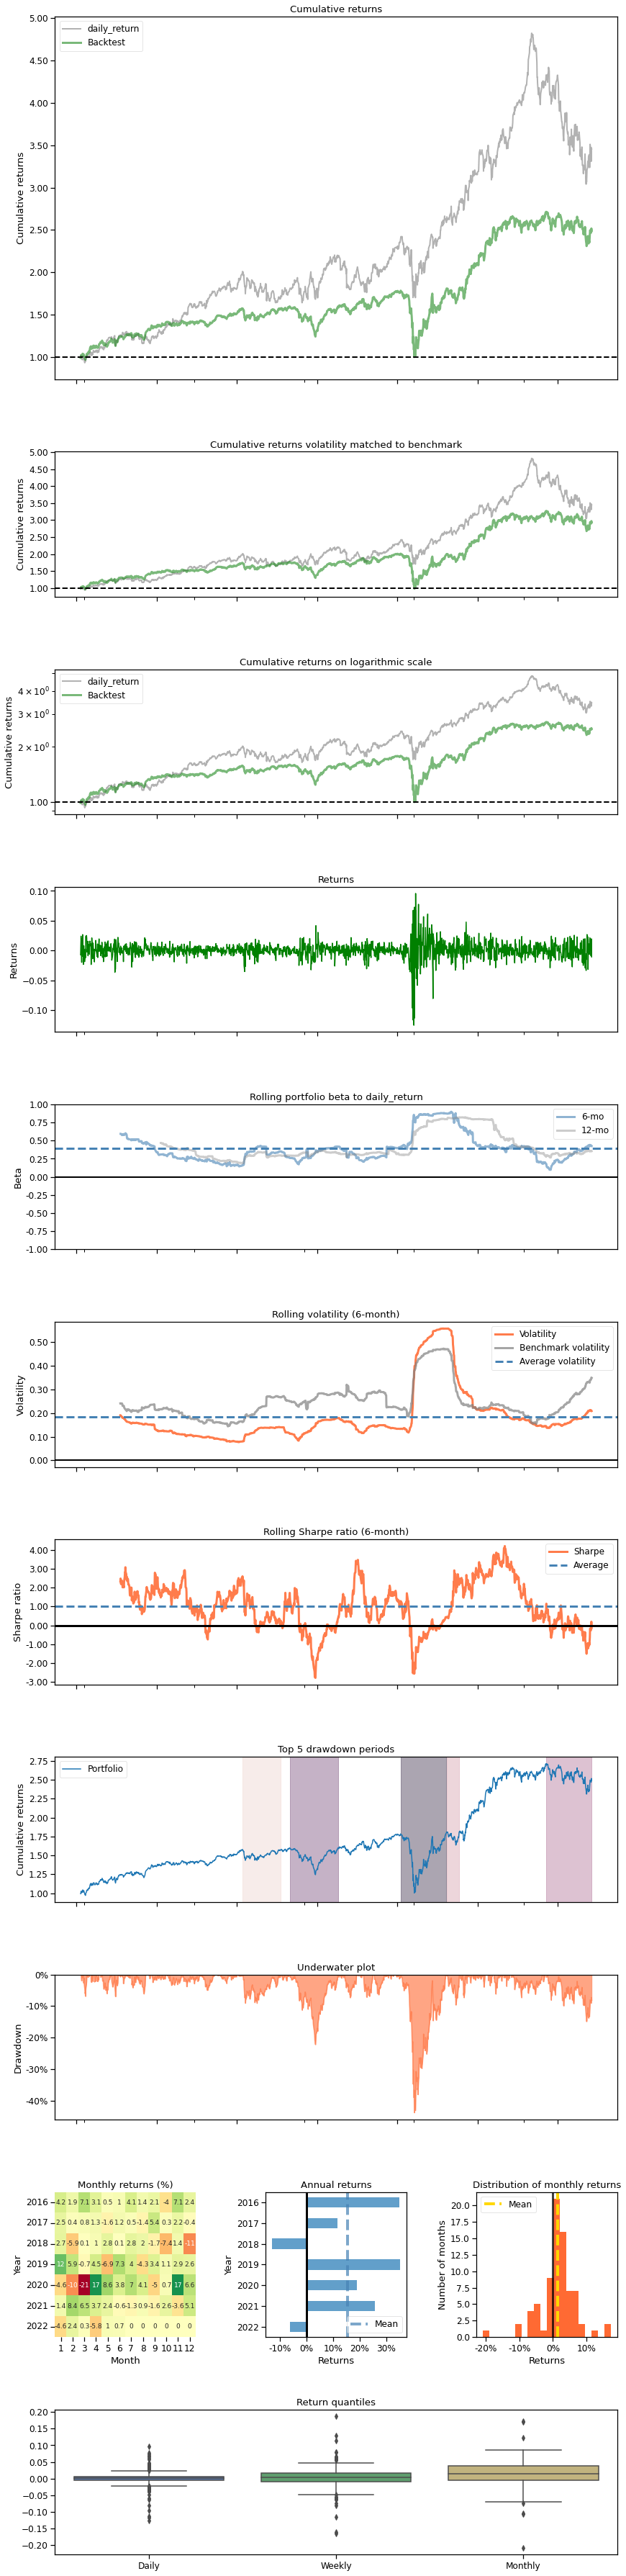

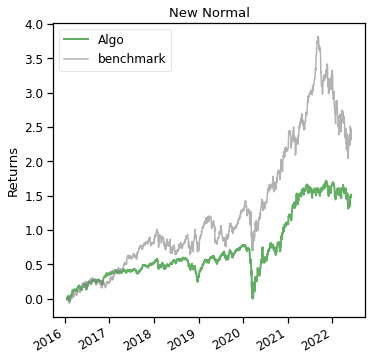

In [101]:
import pyfolio
%matplotlib inline

#ticker should be ^DJI
baseline_df = get_baseline_test(
        ticker=['A'],
        start=df_daily_return.loc[0,'Date'], end='2022-06-06'
    )

baseline_returns = get_daily_return(baseline_df, value_col_name="Close")
baseline_returns = baseline_returns[1:]
DRL_strat = DRL_strat[1:]
print(baseline_returns)
print(DRL_strat)
with pyfolio.plotting.plotting_context(font_scale=1.1):
        pyfolio.create_full_tear_sheet(returns = DRL_strat,
                                       benchmark_rets=baseline_returns, set_context=False)
        

In [102]:
unique_tic = trade_test.Symbol.unique()
unique_trade_date = trade_test.Date.unique()

In [103]:
portfolio = calculate_portfolio_minimum_variance

In [104]:
portfolio = calculate_portfolio_minimum_variance(df_eval, unique_trade_date)

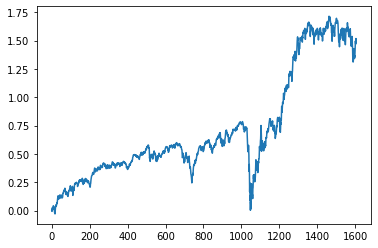

In [105]:
a2c_cumpod =(df_daily_return.daily_return+1).cumprod()-1
min_var_cumpod =(portfolio.account_value.pct_change()+1).cumprod()-1
dji_cumpod =(baseline_returns+1).cumprod()-1
a2c_cumpod.plot()

In [106]:
time_ind = pd.Series(df_daily_return.Date)

In [107]:
trace0_portfolio = go.Scatter(x = time_ind, y = a2c_cumpod, mode = 'lines', name = 'A2C (Portfolio Allocation)')

trace1_portfolio = go.Scatter(x = time_ind, y = dji_cumpod, mode = 'lines', name = 'DJIA')
trace2_portfolio = go.Scatter(x = time_ind, y = min_var_cumpod, mode = 'lines', name = 'Min-Variance')
#trace3_portfolio = go.Scatter(x = time_ind, y = ddpg_cumpod, mode = 'lines', name = 'DDPG')
#trace4_portfolio = go.Scatter(x = time_ind, y = addpg_cumpod, mode = 'lines', name = 'Adaptive-DDPG')
#trace5_portfolio = go.Scatter(x = time_ind, y = min_cumpod, mode = 'lines', name = 'Min-Variance')

#trace4 = go.Scatter(x = time_ind, y = addpg_cumpod, mode = 'lines', name = 'Adaptive-DDPG')

#trace2 = go.Scatter(x = time_ind, y = portfolio_cost_minv, mode = 'lines', name = 'Min-Variance')
#trace3 = go.Scatter(x = time_ind, y = spx_value, mode = 'lines', name = 'SPX')

In [108]:
traces_list = [trace0_portfolio, trace1_portfolio, trace2_portfolio]
plt = plot_portfolio_traces(traces = traces_list, time_ind= time_ind)
plt.show()